# New York City Airbnb Open Data
<br/>
<center>Francesco Di Salvo <br/> <i>Politecnico di Torino <br /> s282418@studenti.polito.it</i></center>
<br />

\*\* Watch <a href="https://github.com/francescodisalvo05/Data-Science-Lab-Exercises/blob/main/Notebooks/report_lab_9_s282418.pdf">here</a> the detailed report

## Data extraction

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('darkgrid')

In [2]:
dev_df = pd.read_csv('../Datasets/NYC_Airbnb/development.csv')
eval_df = pd.read_csv('../Datasets/NYC_Airbnb/evaluation.csv')
labels = eval_df['id']

## Data exploration

In [3]:
dev_df.shape, eval_df.shape

((39116, 16), (9779, 15))

In [4]:
dev_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 39116 entries, 0 to 39115
Data columns (total 16 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              39116 non-null  int64  
 1   name                            39103 non-null  object 
 2   host_id                         39116 non-null  int64  
 3   host_name                       39097 non-null  object 
 4   neighbourhood_group             39116 non-null  object 
 5   neighbourhood                   39116 non-null  object 
 6   latitude                        39116 non-null  float64
 7   longitude                       39116 non-null  float64
 8   room_type                       39116 non-null  object 
 9   price                           39116 non-null  int64  
 10  minimum_nights                  39116 non-null  int64  
 11  number_of_reviews               39116 non-null  int64  
 12  last_review                     

In [6]:
dev_df.isnull().sum()

id                                   0
name                                13
host_id                              0
host_name                           19
neighbourhood_group                  0
neighbourhood                        0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimum_nights                       0
number_of_reviews                    0
last_review                       8041
reviews_per_month                 8041
calculated_host_listings_count       0
availability_365                     0
dtype: int64

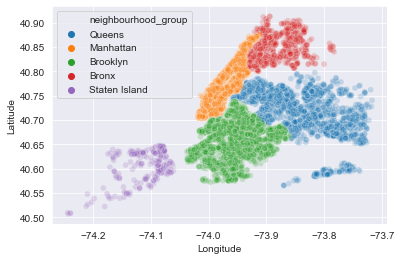

In [7]:
sns.scatterplot(dev_df['longitude'], dev_df['latitude'], alpha=0.2, hue=dev_df.neighbourhood_group)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
# Overleaf doesn't load too many dots -> so I use the png
plt.savefig("Images/report9_img1.png", format="png")

In [8]:
len(set(dev_df.neighbourhood))

221

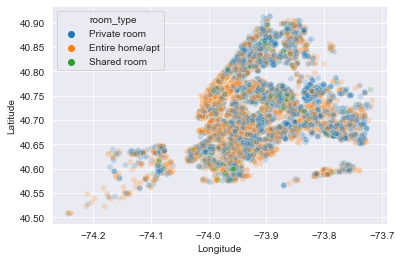

In [9]:
sns.scatterplot(dev_df['longitude'], dev_df['latitude'], alpha=0.2, hue=dev_df.room_type)
plt.ylabel("Latitude")
plt.xlabel("Longitude")
plt.savefig("Images/report9_img2.png", format="png")

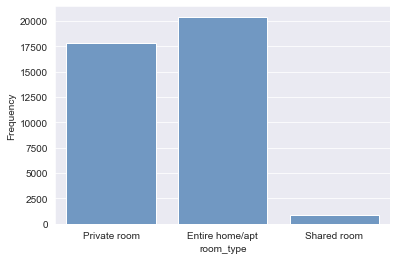

In [18]:
sns.countplot(x="room_type", data=dev_df, color="#6397d0")
plt.ylabel("Frequency")
plt.savefig("Images/report9_img3.svg", format="svg")

## Preprocessing

In [5]:
def clean(df):
    # eliminate unuseful attributes 
    df = df.drop(columns=["name","host_name","last_review"])

    # null values on review_per_month : fill with the average
    df['reviews_per_month'].fillna(0, inplace=True)
        
    return df

def encode_categories(dev, ev, columns):
    for column in columns:

        # concat both dataframes in order to have the same encoding
        # the ones with NaN belong the ev_set
        
        df = pd.concat([dev,ev])
        df[column] = df[column].factorize()[0]
        
        ev = df[df['price'].isna()].drop(columns=['price'])
        dev = df.dropna(subset=['price'])
        
    return dev, ev

In [6]:
columns_to_encode = ['neighbourhood_group', 'room_type','neighbourhood']

dev_df = clean(dev_df)
eval_df = clean(eval_df)

dev_df_enc, eval_df_enc = encode_categories(dev_df.copy(),eval_df.copy(),columns_to_encode)

In [21]:
dev_df_enc.corr()['price'].sort_values(ascending=False)

price                             1.000000
room_type                         0.204980
availability_365                  0.082667
calculated_host_listings_count    0.055070
minimum_nights                    0.044238
latitude                          0.031274
host_id                           0.015168
id                                0.009273
neighbourhood                    -0.013436
number_of_reviews                -0.048254
neighbourhood_group              -0.049987
reviews_per_month                -0.053285
longitude                        -0.148891
Name: price, dtype: float64

## Model selection and hyperparameters tuning

In [7]:
y_dev = dev_df_enc.price
X_dev = dev_df_enc.drop(columns=['price'])
X_eval = eval_df_enc

In [57]:
## LINEAR REGRESSION ##
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV

def doLinearReg(in_X,in_y):
    
    model = LinearRegression()
    parameters = {'fit_intercept':[True,False], 'normalize':[True,False]}
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='r2',
                         cv=5,
                         n_jobs=-1)

    gs.fit(in_X, in_y)
    best_parameters_LR = gs.best_params_  
    best_score_LR = gs.best_score_ 
    print(best_parameters_LR)
    print(best_score_LR)

gs_lr = doLinearReg(X_dev,y_dev)

{'fit_intercept': True, 'normalize': True}
0.07814678753904299


In [58]:
## RANDOM FOREST ##
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def doRandomForest(in_X,in_y):
    
    model = RandomForestRegressor(n_jobs=4)
    
    parameters = {
        "n_estimators": [300, 500, 700],
        "max_features": ["auto", "sqrt", "log2"],
        "random_state": [42],
    }
    
    gs = GridSearchCV(estimator=model,  
                         param_grid=parameters,
                         scoring='r2',
                         cv=5,
                         n_jobs=4,
                         verbose=True)

    
    gs.fit(in_X, in_y)
    best_parameters = gs.best_params_  
    best_score = gs.best_score_ 
    print(best_parameters)
    print(best_score)
    
    return gs
    
gs_rf = doRandomForest(X_dev,y_dev)

## senza id : {'max_features': 'sqrt', 'n_estimators': 500, 'random_state': 42} 0.19266372618803254
## con tutti i parametri : 

Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  45 out of  45 | elapsed: 11.6min finished


{'max_features': 'sqrt', 'n_estimators': 700, 'random_state': 42}
0.20900244019510553


## Evaluation and deploy

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

X_train, X_test, y_train, y_test = train_test_split(X_dev,y_dev,test_size=0.2,random_state=105)

rf = RandomForestRegressor(n_estimators=700,max_features='sqrt')
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

In [ ]:
rf_pred_final = gs_rf.predict(X_eval)

pd.DataFrame( dict(Id = eval_df['id'],
                   Predicted = rf_pred_final)
            ).to_csv("submissionL9.csv",sep=",",index=False)

##   public score : 0.281
##   1st place in the public leaderboard

In [83]:
""" NAIVE SOLUTION """
rf_naive = RandomForestRegressor()
rf_naive.fit(X_naive,y_naive)
naive = rf_naive.predict(eval_naive_enc)

pd.DataFrame( dict(Id = eval_df['id'],
                   Predicted = naive)
            ).to_csv("submissionL9_naive.csv",sep=",",index=False)

## Developement and evaluation comparison

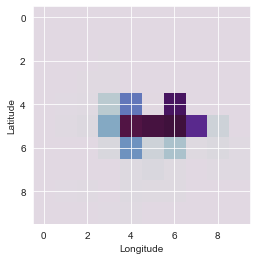

In [12]:
import numpy as np
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,1)

heatmap1, _, _ = np.histogram2d(dev_df['longitude'], 
                                dev_df['latitude'], 
                                weights=dev_df.price)


plt.imshow(heatmap1,cmap=plt.cm.get_cmap('twilight'))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig("Images/report9_img4.svg", format="svg")

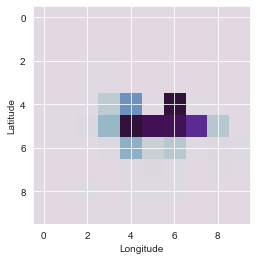

In [27]:
eval_df_price = eval_df.join(pd.DataFrame( dict(Id = eval_df['id'],Predicted = rf_pred_final)), 
                             lsuffix='_caller', rsuffix='_other')

heatmap2, _, _ = np.histogram2d(eval_df_price['longitude'], 
                                eval_df_price['latitude'], 
                                weights=eval_df_price.Predicted)

fig, ax = plt.subplots(1,1)
plt.imshow(heatmap2,cmap=plt.cm.get_cmap('twilight'))
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")

plt.savefig("Images/report9_img5.svg", format="svg")